<a href="https://colab.research.google.com/github/EWHA-AI24-Project/Weather-to-Wildfire-Prediction/blob/main/notebooks/connecting_func/external_function_with_plot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install catboost
from sklearn.multioutput import MultiOutputRegressor

class MyMultiOutputWrapper:
    def __init__(self, estimators):
        self.estimators_ = estimators

    def predict(self, X):
        import numpy as np
        preds = [est.predict(X) for est in self.estimators_]
        return np.array(preds).T

    def fit(self, X, y):
        for i, est in enumerate(self.estimators_):
            est.fit(X, y[:, i])
        return self
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
import pandas as pd
import numpy as np
import joblib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.5 MB/s eta 0:00:00


In [ ]:
# Get input from the user
def get_user_input():
    year = int(input("예측할 연도를 입력하세요 (예: 2026): "))
    month = int(input("예측할 월을 입력하세요 (1~12): "))
    return year, month

In [ ]:
# One-hot encoding for Model 1
# Transform input data for Model 1
# Apply one-hot encoding to the MONTH column and adjust the order and missing columns to match model1_columns
def convert_to_model1_input(year, month, model1_columns):
    df = pd.DataFrame([[year, month]], columns=['YEAR', 'MONTH'])

    df['YEAR_SINCE_2000'] = year - 2000
    df['LINEAR_TEMP_TREND'] = 0.017 * df['YEAR_SINCE_2000']
    df['YEAR_MONTH_INDEX'] = df['YEAR_SINCE_2000'] * 12 + df['MONTH']
    df['YEAR_SQUARED'] = df['YEAR_SINCE_2000'] ** 2
    # One-hot encoding
    df = pd.get_dummies(df, columns=['MONTH'], prefix='MONTH')

    # Set all missing columns to 0.0
    for col in model1_columns:
        if col not in df.columns:
            df[col] = 0.0

    # Reorder columns
    df = df[model1_columns]
    return df

In [ ]:
def predict_climate(model1, X_input1):
    y_pred = model1.predict(X_input1)[0]

    max_temp = y_pred[0]
    min_temp = y_pred[1]
    wind_speed = y_pred[2]
    temp_range = y_pred[3]
    precipitation = y_pred[4]
    return [max_temp, min_temp, wind_speed, temp_range, precipitation]

In [ ]:
# Transform Model 1 output + extra info into Model 2 input
def convert_to_model2_input(model1_output, month, model2_columns):
    max_temp, min_temp, wind_speed, temp_range, precipitation = model1_output

    season = convert_month_to_season(month)
    season_cols = ['SEASON_Spring', 'SEASON_Summer', 'SEASON_Fall', 'SEASON_Winter']
    season_encoding = {col: 1 if col.endswith(season) else 0 for col in season_cols}

    input_dict = {
        'MAX_TEMP': max_temp,
        'MIN_TEMP': min_temp,
        'AVG_WIND_SPEED': wind_speed,
        'TEMP_RANGE': temp_range,
        'PRECIPITATION': precipitation,
        **season_encoding
    }
    input_df = pd.DataFrame([input_dict])
    input_df = input_df.reindex(columns=model2_columns, fill_value=0)
    return input_df

In [ ]:
def convert_month_to_season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'
    else:
        return 'Winter'

In [ ]:
# 모델2로 산불 확률 예측
def predict_fire_probability(model2, X_input2):
    prob = model2.predict_proba(X_input2)[0][1]
    return prob

In [ ]:
def run_fire_risk_prediction(model1, model2, model1_columns, model2_columns):
    year, month = get_user_input()

    X_model1 = convert_to_model1_input(year, month, model1_columns)
    climate_pred = predict_climate(model1, X_model1)

    X_model2 = convert_to_model2_input(climate_pred, month, model2_columns)

    fire_prob = predict_fire_probability(model2, X_model2)
    print(f"\n✅ 예측 결과: {year}년 {month}월의 산불 발생 확률은 **{fire_prob*100:.2f}%** 입니다.")


In [ ]:
model1 = joblib.load("stacking_catboost_model.pkl")
model2 = joblib.load("rf_final_model.pkl")

model1_columns = ['YEAR_SINCE_2000'] + [f'MONTH_{i}' for i in range(1, 13)] + ['LINEAR_TEMP_TREND', 'YEAR_MONTH_INDEX', 'YEAR_SQUARED']
model2_columns = [
    'PRECIPITATION', 'MAX_TEMP', 'MIN_TEMP', 'AVG_WIND_SPEED', 'TEMP_RANGE',
    'SEASON_Fall', 'SEASON_Spring', 'SEASON_Summer', 'SEASON_Winter'
]

In [ ]:
run_fire_risk_prediction(model1, model2, model1_columns, model2_columns)

예측할 연도를 입력하세요 (예: 2026): 2029
예측할 월을 입력하세요 (1~12): 4

✅ 예측 결과: 2029년 4월의 산불 발생 확률은 **13.64%** 입니다.


In [ ]:
run_fire_risk_prediction(model1, model2, model1_columns, model2_columns)

예측할 연도를 입력하세요 (예: 2026): 2030
예측할 월을 입력하세요 (1~12): 8

✅ 예측 결과: 2030년 8월의 산불 발생 확률은 **80.22%** 입니다.


In [ ]:
run_fire_risk_prediction(model1, model2, model1_columns, model2_columns)

예측할 연도를 입력하세요 (예: 2026): 2040
예측할 월을 입력하세요 (1~12): 8

✅ 예측 결과: 2040년 8월의 산불 발생 확률은 **79.04%** 입니다.


In [ ]:
run_fire_risk_prediction(model1, model2, model1_columns, model2_columns)

예측할 연도를 입력하세요 (예: 2026): 2045
예측할 월을 입력하세요 (1~12): 8

✅ 예측 결과: 2045년 8월의 산불 발생 확률은 **78.07%** 입니다.


In [ ]:
run_fire_risk_prediction(model1, model2, model1_columns, model2_columns)

예측할 연도를 입력하세요 (예: 2026): 2029
예측할 월을 입력하세요 (1~12): 10

✅ 예측 결과: 2029년 10월의 산불 발생 확률은 **26.45%** 입니다.


In [ ]:
run_fire_risk_prediction(model1, model2, model1_columns, model2_columns)

예측할 연도를 입력하세요 (예: 2026): 2030
예측할 월을 입력하세요 (1~12): 10

✅ 예측 결과: 2030년 10월의 산불 발생 확률은 **22.87%** 입니다.


In [ ]:
run_fire_risk_prediction(model1, model2, model1_columns, model2_columns)

예측할 연도를 입력하세요 (예: 2026): 2040
예측할 월을 입력하세요 (1~12): 10

✅ 예측 결과: 2040년 10월의 산불 발생 확률은 **33.34%** 입니다.


In [ ]:
run_fire_risk_prediction(model1, model2, model1_columns, model2_columns)

예측할 연도를 입력하세요 (예: 2026): 2050
예측할 월을 입력하세요 (1~12): 10

✅ 예측 결과: 2050년 10월의 산불 발생 확률은 **23.93%** 입니다.


In [ ]:
run_fire_risk_prediction(model1, model2, model1_columns, model2_columns)

예측할 연도를 입력하세요 (예: 2026): 2030
예측할 월을 입력하세요 (1~12): 9

✅ 예측 결과: 2030년 9월의 산불 발생 확률은 **52.35%** 입니다.


In [ ]:
run_fire_risk_prediction(model1, model2, model1_columns, model2_columns)

예측할 연도를 입력하세요 (예: 2026): 2060
예측할 월을 입력하세요 (1~12): 9

✅ 예측 결과: 2060년 9월의 산불 발생 확률은 **63.03%** 입니다.


In [ ]:
import matplotlib.pyplot as plt

def plot_fire_risk_by_month(model1, model2, model1_columns, model2_columns, year):
    month_list = list(range(1, 13))
    fire_probs = []

    for month in month_list:
        # 모델1 입력 구성 → 기후 예측
        X_model1 = convert_to_model1_input(year, month, model1_columns)
        climate_pred = predict_climate(model1, X_model1)

        # 모델2 입력 구성 → 산불 확률 예측
        X_model2 = convert_to_model2_input(climate_pred, month, model2_columns)
        fire_prob = predict_fire_probability(model2, X_model2)

        fire_probs.append(fire_prob)

    # 그래프 그리기
    plt.figure(figsize=(10, 5))
    plt.plot(month_list, [p * 100 for p in fire_probs], marker='o', color='orangered')
    plt.xticks(month_list)
    plt.xlabel('Month')
    plt.ylabel('Predicted Fire Risk (%)')
    plt.title(f'Predicted Monthly Wildfire Risk in {year}')
    plt.grid(True)
    plt.ylim(0, 100)
    plt.show()


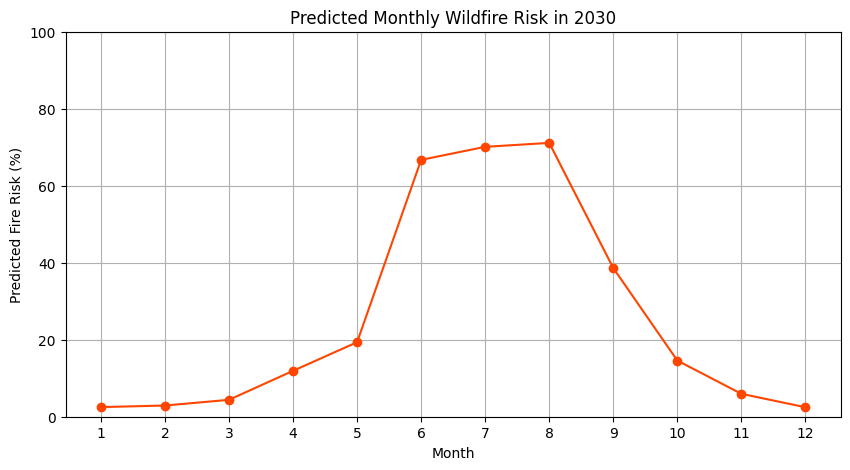

In [ ]:
plot_fire_risk_by_month(model1, model2, model1_columns, model2_columns, year=2030)


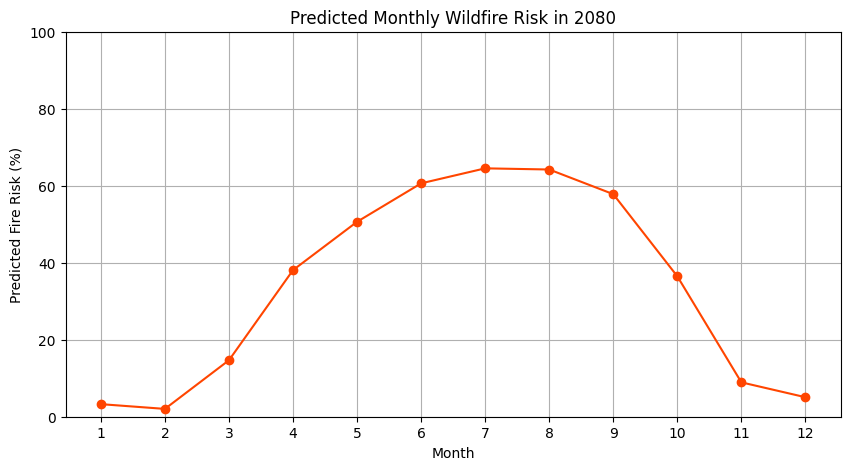

In [ ]:
plot_fire_risk_by_month(model1, model2, model1_columns, model2_columns, year=2080)

In [ ]:
import matplotlib.pyplot as plt

def plot_fire_risk_by_year(model1, model2, model1_columns, model2_columns, month, start_year=2026, end_year=2080):
    year_range = range(start_year, end_year + 1)
    fire_probs = []

    for year in year_range:
        # 모델1 입력 구성 → 기후 예측
        X_model1 = convert_to_model1_input(year, month, model1_columns)
        climate_pred = predict_climate(model1, X_model1)

        # 모델2 입력 구성 → 산불 확률 예측
        X_model2 = convert_to_model2_input(climate_pred, month, model2_columns)
        fire_prob = predict_fire_probability(model2, X_model2)

        fire_probs.append(fire_prob)

    # 그래프 그리기
    plt.figure(figsize=(12, 6))
    plt.plot(year_range, [p * 100 for p in fire_probs], marker='o', color='firebrick')
    plt.xlabel('Year')
    plt.ylabel('Predicted Fire Risk (%)')
    plt.title(f'Predicted Wildfire Risk in MONTH({month}) from {start_year} to {end_year}')
    plt.grid(True)
    plt.ylim(0, 100)
    plt.show()


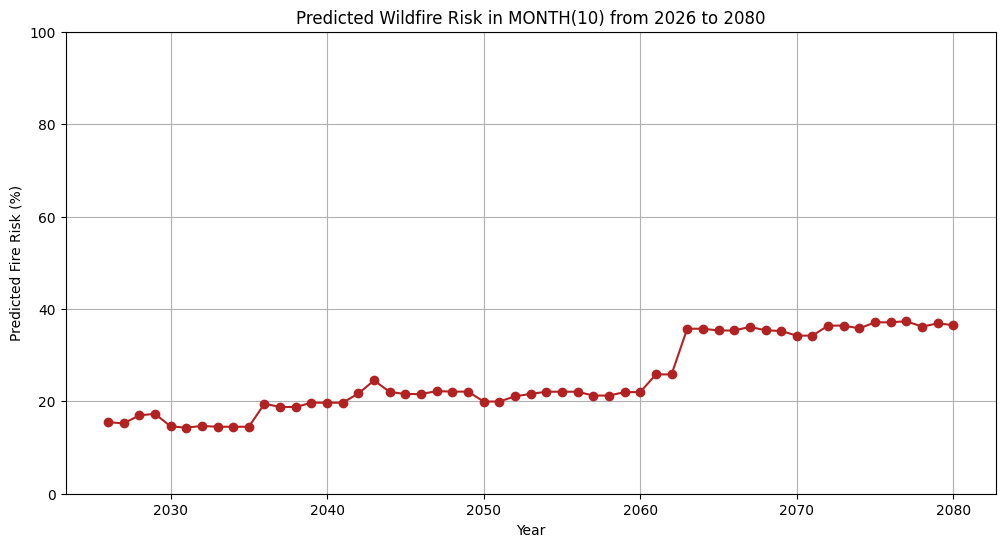

In [ ]:
plot_fire_risk_by_year(model1, model2, model1_columns, model2_columns, month=10)


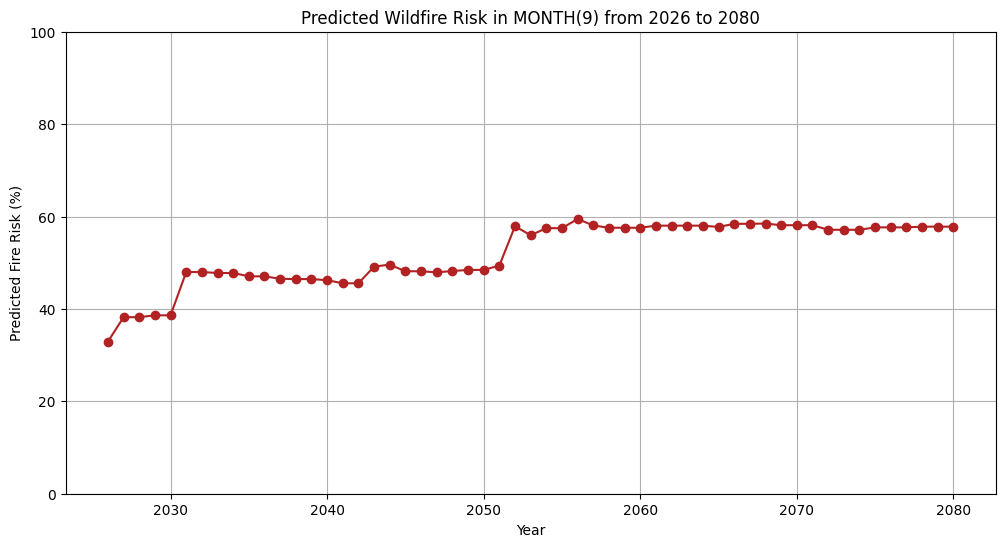

In [ ]:
plot_fire_risk_by_year(model1, model2, model1_columns, model2_columns, month=9)

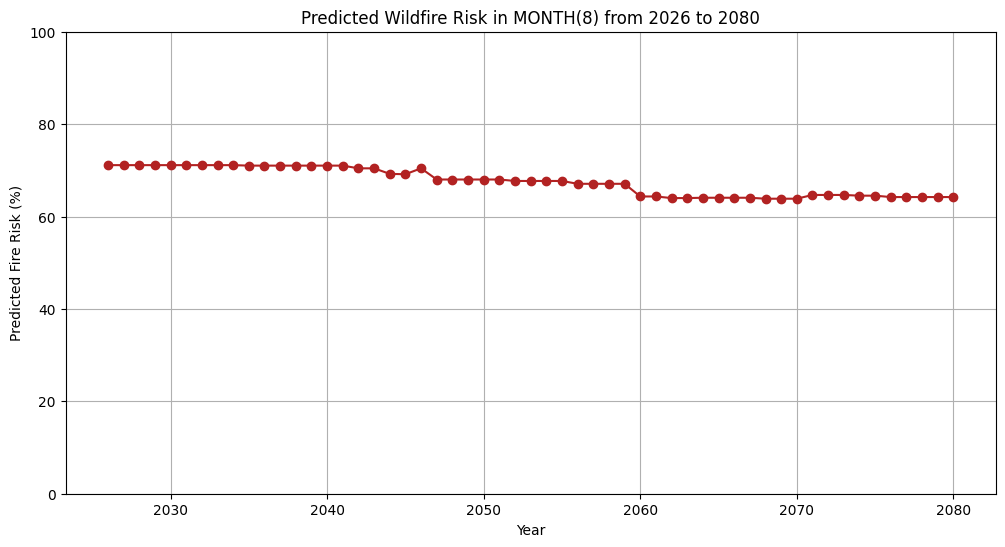

In [ ]:
plot_fire_risk_by_year(model1, model2, model1_columns, model2_columns, month=8)

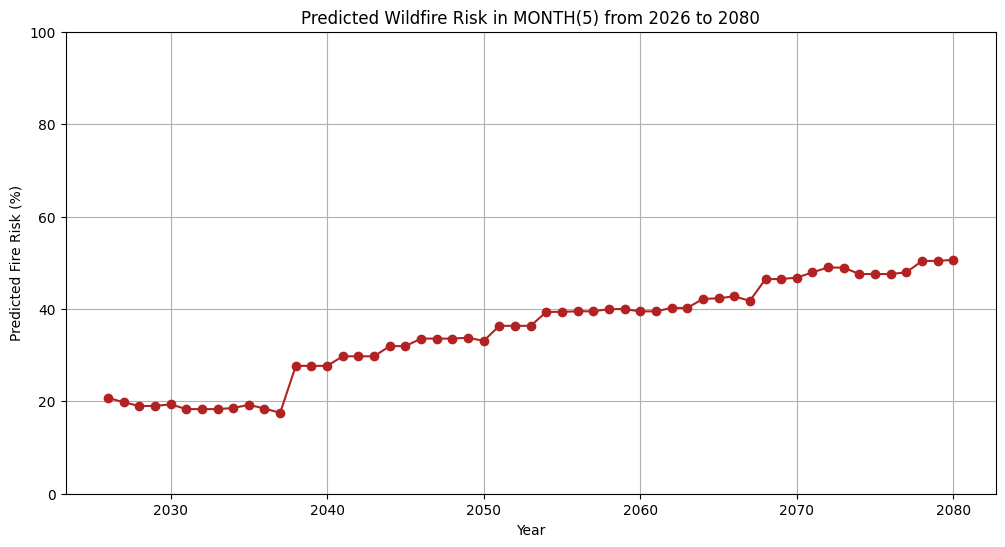

In [ ]:
plot_fire_risk_by_year(model1, model2, model1_columns, model2_columns, month=5)